In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time
import math

from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, gates, noises, observables, Gate
from braket.devices import LocalSimulator
from braket.parametric import FreeParameter
import numpy as np
from scipy.stats import unitary_group

from braket.circuits.noise_model import (
    GateCriteria,
    NoiseModel,
    ObservableCriteria,
)
from braket.circuits import Circuit, Observable, Gate
from braket.circuits.noises import (
    BitFlip,
    Depolarizing,
    TwoQubitDepolarizing,
)

Make Circuit

In [3]:
# build a simple circuit
circ = Circuit().h(0).cnot(0,1)

# define a noise channel
noise = noises.BitFlip(probability=0.1)

# add noise to every gate in the circuit
circ.apply_gate_noise(noise)

#noise add

# select the local noise simulator
device = LocalSimulator('braket_dm')

# run the circuit on the local simulator
task = device.run(circ, shots = 1000)

# visualize the results
result = task.result()
measurement = result.measurement_counts
print('measurement results:', measurement)

print('result: ', result)

measurement results: Counter({'11': 411, '00': 406, '10': 95, '01': 88})
result:  GateModelQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='f0a3b39a-a08a-4a4c-b582-9292baee22f0', shots=1000, deviceId='braket_dm', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), additional_metadata=AdditionalMetadata(action=Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source='OPENQASM 3.0;\nbit[2] b;\nqubit[2] q;\nh q[0];\n#pragma braket noise bit_flip(0.1) q[0]\ncnot q[0], q[1];\n#pragma braket noise bit_flip(0.1) q[0]\n#pragma braket noise bit_flip(0.1) q[1]\nb[0] = measure q[0];\nb[1] = measure q[1];', inputs={}), dwaveMetadata=None, ionqMetadata=None, rigettiMetadata=None, oqcMetadata=None, xanaduMetadata=None, queraMetadata=None, simulatorMetadata=None), result_types=[], values=[], measurements=array([[1, 1],
       [0, 

Questions:
1. what add measurement results mean?
2. 

# Noise Suite


In [4]:
def noise_model():
    """given noise model by AWS

    Returns:
        _type_: _description_
    """
    rng = np.random.default_rng()
    m = NoiseModel()
    
    two_q_depo_mu = 1 - 0.9311
    two_q_depo_sigma = 0.005
    bf_mu = 1 - 0.99752
    bf_sigma = 0.0015
    one_q_depo_mu = 1 - 0.9981
    one_q_depo_sigma = 0.00017
    for qi in range(11):
        z_bf_prob = bf_mu + bf_sigma * rng.standard_normal()
        z_bf_prob = 0.0 if z_bf_prob < 0.0 else z_bf_prob
        
        bf_prob = bf_mu + bf_sigma * rng.standard_normal()
        bf_prob = 0.0 if bf_prob < 0.0 else bf_prob
        
        one_q_depo_prob = one_q_depo_mu + one_q_depo_sigma * rng.standard_normal()
        one_q_depo_prob = 0.0 if one_q_depo_prob < 0.0 else one_q_depo_prob
        
        m.add_noise(BitFlip(z_bf_prob), ObservableCriteria(observables=Observable.Z, qubits=qi))
        #m.add_noise(BitFlip(bf_prob), ObservableCriteria(qubits=qi))
        
        m.add_noise(Depolarizing(one_q_depo_prob), GateCriteria(qubits=qi))
        for qj in range(11):
            if not qj == qi:
                two_q_depo_prob = two_q_depo_mu + two_q_depo_sigma * rng.standard_normal()
                two_q_depo_prob = 0.0 if two_q_depo_prob < 0.0 else two_q_depo_prob
                
                m.add_noise(TwoQubitDepolarizing(two_q_depo_prob), GateCriteria(gates=[Gate.CNot, Gate.Swap, Gate.CPhaseShift], qubits=[qi, qj]))
    return m

# # build my circuit here
# c = Circuit()
# # SOME GATES GET APPLIED

# # examine the noiseless circuit 
# print(c)

# # apply the noise model to the circuit 
# given_noise_model = noise_model()
# c = given_noise_model.apply(c)

# print(c)

def test_noise_suite(circ, noise_dict, measurements = {}):
    """runs given noise_dict into circ, return measurements

    Args:
        circ (_type_): _description_
        noise_dict (dict): _description_
        measurements (dict, optional): _description_. Defaults to {}.

    Returns:
        dict: measurements
    """
    original_circ = circ
    #state vector run
    measurement = run_circuit(circ, 'braket_sv')
    measurements['braket_sv']=measurement

    # apply the noise model to the circuit 
    given_noise_model = noise_model()
    circ = given_noise_model.apply(circ)
    print('Circuit after applying'+ 'given_noise_model')
    print(circ)
    measurement = run_circuit(circ, 'braket_dm')
    measurements['given_noise_model']=measurement
    #rebase circ
    circ = original_circ

    for key in noise_dict.keys():
        dynamic_noise_func = getattr(noises, key)
        noise = dynamic_noise_func(noise_dict[key])

        # add noise to every gate in the circuit
        circ.apply_gate_noise(noise)
        print('Circuit after applying'+ key)
        print(circ)
        measurement = run_circuit(circ, 'braket_dm')
        measurements[key]=measurement
        #rebase circ
        circ = original_circ

    print("Measurements from noise suite")
    for item in measurements.items():
        print(item)

    return measurements

def run_circuit(circ, simulator_type):
    """run circuit with given simulator type

    Args:
        circ (_type_): _description_
        simulator_type (_type_): _description_

    Returns:
        dict: measurement
    """
    # select the local noise simulator
    device = LocalSimulator(simulator_type)

    # run the circuit on the local simulator
    task = device.run(circ, shots = 1000)

    # visualize the results
    result = task.result()
    measurement = result.measurement_counts
    return measurement

def plot_measurements(measurements):
    for key, counts in measurements.items():
        # plot results: see effects of noise
        plt.bar(counts.keys(), counts.values(), label= key)
        plt.title("Base Graph on Noise Type: " + key)
        plt.xlabel('bitstrings')
        plt.ylabel('counts')
        plt.tight_layout()
        plt.legend()
        plt.savefig(key+'.png', dpi=700)

def benchmark_measurements(measurements):
    """find average difference between state vector counts and noise simulations

    Args:
        measurements (_type_): _description_

    Returns:
        _type_: _description_
    """
    total_difference = 0
    noise_count = len(measurements) - 1
    sv_benchmark = measurements['braket_sv']
    
    for key, counts in measurements.items():
        #print("in measurements for key: ", key, "counts: ", counts)
        if key != 'braket_sv':
            for key_bit, value_count in sv_benchmark.items():
                total_difference += value_count - counts[key_bit]
                #print("total difference: ", total_difference)
    average_difference = total_difference/noise_count
    print("Average difference: ", average_difference)
    return average_difference


## Example usage

In [5]:
# build a simple circuit
#circ = Circuit().h(0).h(1).cnot(0,1).cnot(1,2).cnot(2,3)
circ = Circuit().h(0).cnot(0,1)

print('Circuit Noiseless')
print(circ)

noise_dict = {'BitFlip': 0.1, 'PhaseFlip': 0.1, 'Depolarizing': 0.1, 'AmplitudeDamping':0.1, 'PhaseDamping':0.1}
#noise_dict = {'BitFlip': 0.1, 'PhaseFlip': 0.1, 'Depolarizing': 0.1, 'AmplitudeDamping':0.1, 'GeneralizedAmplitudeDamping': [0.1, 0.1], 'PhaseDamping':0.1, 'PauliChannel': [0.1, 0.1, 0.1]}

#using noise suite
measurements = test_noise_suite(circ, noise_dict)


Circuit Noiseless
T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|
Circuit after applyinggiven_noise_model
T  : |      0       |      1      |
                                   
q0 : -H-DEPO(0.0018)-C-DEPO(0.073)-
                     | |           
q1 : ----------------X-DEPO(0.073)-

T  : |      0       |      1      |
Circuit after applyingBitFlip
T  : |    0    |    1    |
                          
q0 : -H-BF(0.1)-C-BF(0.1)-
                |         
q1 : -----------X-BF(0.1)-

T  : |    0    |    1    |
Circuit after applyingPhaseFlip
T  : |        0        |        1        |
                                          
q0 : -H-PF(0.1)-BF(0.1)-C-PF(0.1)-BF(0.1)-
                        |                 
q1 : -------------------X-PF(0.1)-BF(0.1)-

T  : |        0        |        1        |
Circuit after applyingDepolarizing
T  : |             0             |             1             |
                                                              
q0 : -H-DEPO(

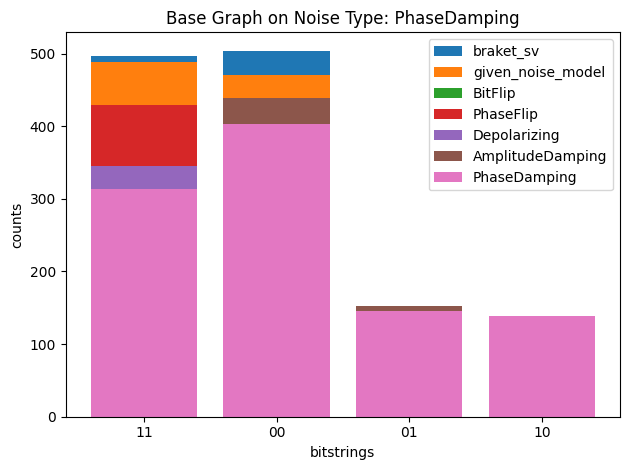

In [6]:
plot_measurements(measurements)

### Average difference between state vector and noise simulation counts.
Lower is better

In [7]:
avg_diff = benchmark_measurements(measurements)


Average difference:  202.33333333333334
